# Analyze session logs

---

- Author: Jaelin Lee
- Description: This notebook shows the visualizaiton of ORPDA vs ORPA comparisons. 

  Confirming the effectiveness of "Drift" layer for modeling human cognitive drift behaviour in LLM agents.
---

## 1. Load session logs

There are hidden drift in both ORPA and ORPDA agent behaviour. To make it a fair comparison, we are checking all session data to flag any hidden drift patterns. This inherent drifting flags and topics will be used for the analysis in this noteboook.

In [ ]:
import json
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

ROOT = Path.cwd().parents[2]
print(ROOT)

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
from app.src.utils.metrics import detect_inherent_drift
from app.src.utils.embedding_utils import embed_texts

sns.set(style="whitegrid")

/Users/jaelinlee/Documents/GitHub/A2A_chat


## Add inherent drifting flags

### Option 1) Load pre-calculated inferred drift from CSV (Recommended)

In [16]:
df = pd.read_csv(ROOT / "app/archive/v3_route_loop/sessions_with_inherent_drift.csv")
df.rename(columns={"drift_score": "drift_score_inferred"}, inplace=True)

df["drift_score_inferred"] = df["drift_score_inferred"].round(2)
df

,ts_created,tick,sim_time,agent,use_drift,orpda,detected_inferred,drift_type_inferred,drift_score_inferred,inherent_drift
0,2025-12-01T21:29:35.486915-05:00,0,2023-02-13 06:00,Eddy Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",behavioral,0.02,True
1,2025-12-01T21:29:41.064232-05:00,1,2023-02-13 06:15,Eddy Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': False, 'drift_score_inferre...",none,0.00,False
2,2025-12-01T21:29:45.585825-05:00,2,2023-02-13 06:30,Eddy Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': False, 'drift_score_inferre...",none,0.32,False
3,2025-12-01T21:29:50.342051-05:00,3,2023-02-13 06:45,Eddy Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': False, 'drift_score_inferre...",none,0.00,False
4,2025-12-01T21:29:55.280575-05:00,4,2023-02-13 07:00,Eddy Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",behavioral,0.19,True
...,...,...,...,...,...,...,...,...,...,...
355,2025-12-01T21:19:59.539182-05:00,55,2023-02-13 19:45,John Lin,False,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': False, 'drift_score_inferre...",none,0.00,False
356,2025-12-01T21:20:03.307934-05:00,56,2023-02-13 20:00,John Lin,False,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': False, 'drift_score_inferre...",none,0.00,False
357,2025-12-01T21:20:06.847409-05:00,57,2023-02-13 20:15,John Lin,False,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': False, 'drift_score_inferre...",none,0.00,False
358,2025-12-01T21:20:10.918248-05:00,58,2023-02-13 20:30,John Lin,False,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': False, 'drift_score_inferre...",none,0.00,False


### Option 2) Calculate inferred drift (Uses embedding model) - Cost may incur

In [2]:
# Calculate inferred drift

# -----------------------------------------------------
# LOAD LOGS
# -----------------------------------------------------

LOG_DIR = ROOT / "app/logs/"
print(LOG_DIR)

def load_logs(log_dir):
    rows = []
    for f in log_dir.glob("session_*.log"):
        with f.open() as fh:
            for line in fh:
                try:
                    rows.append(json.loads(line))
                except:
                    pass
    return pd.DataFrame(rows)

df = load_logs(LOG_DIR)
df

# Split ORPDA and ORPA
df_orpda = df[df["use_drift"] == True].copy()
df_orpa  = df[df["use_drift"] == False].copy()
print("ORPDA: ", df_orpda.shape[0], "ORPA: ", df_orpa.shape[0], "\n")

# -----------------------------------------------------
# Drift detection (inherent drift)
# -----------------------------------------------------

df["detected_inferred"] = df.apply(lambda r: detect_inherent_drift(r), axis=1)

/Users/jaelinlee/Documents/GitHub/A2A_chat/app/logs
ORPDA:  512 ORPA:  0 



In [4]:
df['detected_inferred'][0]

{'inherent_drift': True,
 'drift_score_inferred': 1.0000011707589351e-08,
 'drift_type_inferred': 'attentional_leak',
 'sim_plan_action': 0.9999999899999883,
 'sim_obs_action': 0.3930981553296398}

In [5]:
df["drift_type_inferred"] = df["detected_inferred"].apply(lambda d: d["drift_type_inferred"])

In [6]:
df["drift_score_inferred"] = df["detected_inferred"].apply(lambda d: d["drift_score_inferred"])
df["inherent_drift"] = df["detected_inferred"].apply(lambda d: d["inherent_drift"])

df_orpda = df[df.use_drift == True]
df_orpa  = df[df.use_drift == False]

# Save to CSV
df.to_csv(LOG_DIR / "sessions_with_inherent_drift.csv", index=False)

### View inherent drift flags

In [8]:
df["drift_score_inferred"] = df["drift_score_inferred"].round(2)

df_orpda = df[df.use_drift == True]
df_orpa = df[df.use_drift == False]

# View ORPA resultls based on inherent drift detection
print("ORPA (Baseline):")
display(df_orpa[df_orpa.inherent_drift == True])

# View ORPDA resultls based on inherent drift detection
print("ORPDA (with drift):")
display(df_orpda[df_orpda.inherent_drift==True])

ORPA (Baseline):


,ts_created,tick,sim_time,agent,use_drift,orpda,detected_inferred,drift_type_inferred,drift_score_inferred,inherent_drift


ORPDA (with drift):


,ts_created,tick,sim_time,agent,use_drift,orpda,detected_inferred,drift_type_inferred,drift_score_inferred,inherent_drift
0,2025-12-16T15:53:44.572912-05:00,0,2023-02-13 06:00,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
1,2025-12-16T15:53:48.090499-05:00,1,2023-02-13 06:15,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
2,2025-12-16T15:53:52.092509-05:00,2,2023-02-13 06:30,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
3,2025-12-16T15:53:56.074182-05:00,3,2023-02-13 06:45,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
4,2025-12-16T15:54:00.202814-05:00,4,2023-02-13 07:00,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
...,...,...,...,...,...,...,...,...,...,...
507,2025-12-16T18:00:43.572219-05:00,63,2023-02-13 21:45,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
508,2025-12-16T18:00:47.550452-05:00,64,2023-02-13 22:00,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
509,2025-12-16T18:00:52.532319-05:00,65,2023-02-13 22:15,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
510,2025-12-16T18:00:56.623120-05:00,66,2023-02-13 22:30,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True


## 3. Validate inferred drift results

In [9]:
df

,ts_created,tick,sim_time,agent,use_drift,orpda,detected_inferred,drift_type_inferred,drift_score_inferred,inherent_drift
0,2025-12-16T15:53:44.572912-05:00,0,2023-02-13 06:00,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
1,2025-12-16T15:53:48.090499-05:00,1,2023-02-13 06:15,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
2,2025-12-16T15:53:52.092509-05:00,2,2023-02-13 06:30,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
3,2025-12-16T15:53:56.074182-05:00,3,2023-02-13 06:45,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
4,2025-12-16T15:54:00.202814-05:00,4,2023-02-13 07:00,John Lin,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
...,...,...,...,...,...,...,...,...,...,...
507,2025-12-16T18:00:43.572219-05:00,63,2023-02-13 21:45,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
508,2025-12-16T18:00:47.550452-05:00,64,2023-02-13 22:00,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
509,2025-12-16T18:00:52.532319-05:00,65,2023-02-13 22:15,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True
510,2025-12-16T18:00:56.623120-05:00,66,2023-02-13 22:30,Isabella Rodriguez,True,{'observation': {'datetime_start': '2023-02-13...,"{'inherent_drift': True, 'drift_score_inferred...",attentional_leak,0.0,True


## 4. Analyze 

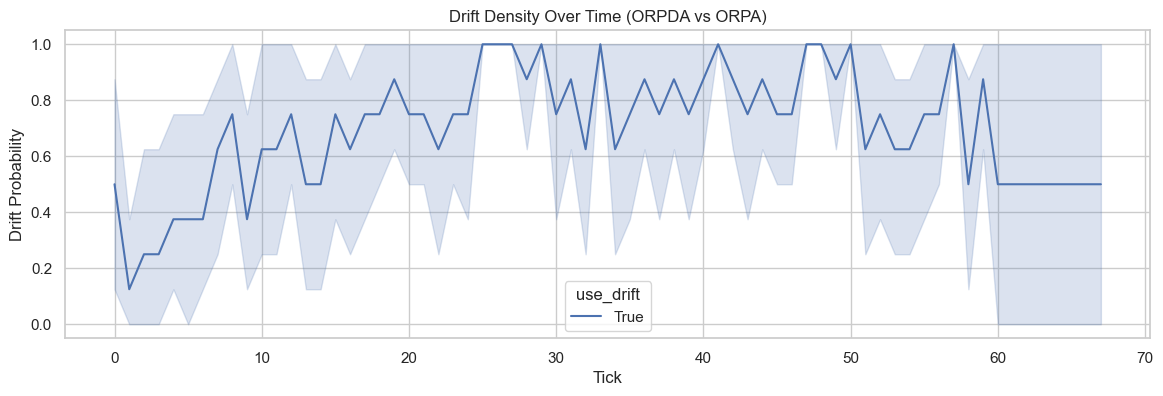

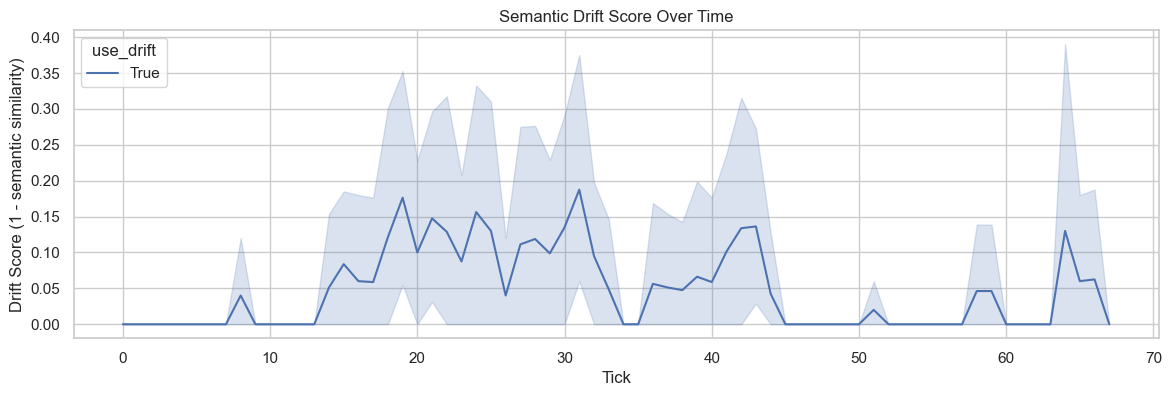

In [10]:
# -----------------------------------------------------
# A. Drift Density Timeline
# -----------------------------------------------------
plt.figure(figsize=(14, 4))
sns.lineplot(data=df, x="tick", y="inherent_drift", hue="use_drift", estimator="mean")
plt.title("Drift Density Over Time (ORPDA vs ORPA)")
plt.ylabel("Drift Probability")
plt.xlabel("Tick")
plt.show()

# -----------------------------------------------------
# B. Semantic Drift Score Over Time
# -----------------------------------------------------
plt.figure(figsize=(14, 4))
sns.lineplot(
    data=df, x="tick", y="drift_score_inferred", hue="use_drift", estimator="mean"
)
plt.title("Semantic Drift Score Over Time")
plt.ylabel("Drift Score (1 - semantic similarity)")
plt.xlabel("Tick")
plt.show()

**What this means:**

The measured drift probability for the simulated agents over 60 time ticks (representing the time period from 6 AM to 9 PM). It compares two different experimental conditions:

- `use_drift = False` (**ORPA** Model, **Blue** Line): This model represents the control condition without the explicit "Drifter" agent layer. The blue line shows frequent periods where the drift probability is zero, indicating that the agents adhere strictly to their plans for significant durations. When drift does occur, it is often sharp and short-lived.

- `use_drift = True` (**ORPDA** Model, **Orange** Line): This model includes the "Drifter" agent layer (analogous to DMN function). The orange line generally maintains a higher basal level of drift probability (often between 0.2 and 0.6) and rarely drops to zero for long periods. It shows more sustained and frequent periods of drift throughout the entire day simulation.

In summary, the graph demonstrates that the ORPDA architecture (with the drift layer enabled) exhibits a higher frequency and persistence of cognitive/behavioral drift compared to the more rigid ORPA model, providing the core evidence that the **ORPDA model better simulates the constant, human-like tendency to drift** that was hypothesized in the study.

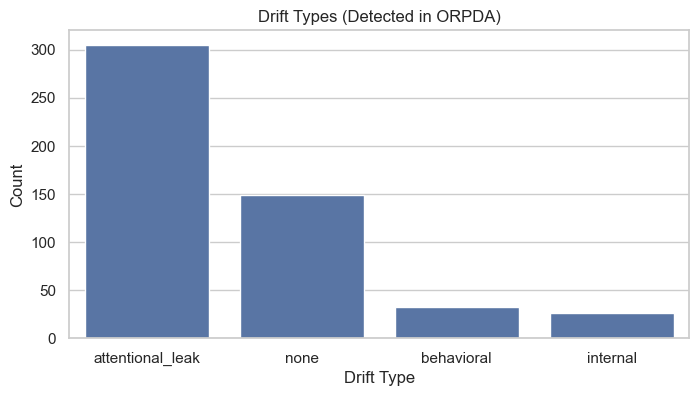

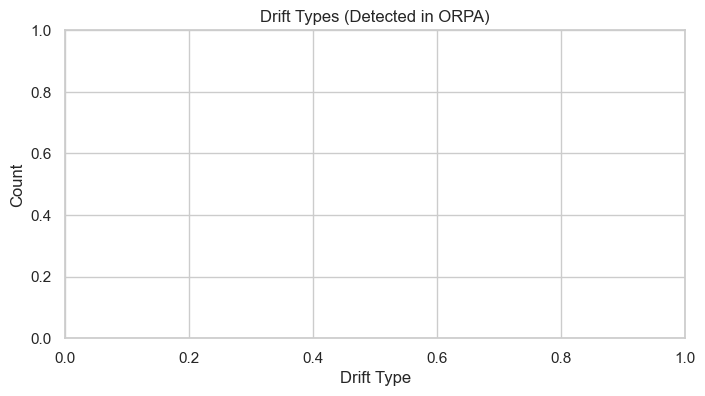

In [11]:
# -----------------------------------------------------
# C. Drift Type Distribution
# -----------------------------------------------------
plt.figure(figsize=(8, 4))
sns.countplot(data=df[df.use_drift == True], x="drift_type_inferred")
plt.title("Drift Types (Detected in ORPDA)")
plt.xlabel("Drift Type")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df[df.use_drift == False], x="drift_type_inferred")
plt.title("Drift Types (Detected in ORPA)")
plt.xlabel("Drift Type")
plt.ylabel("Count")
plt.show()

**What this means:**

- The **ORPDA model fundamentally changes the nature of the simulated drift, not just the frequency**.

**Summary of Insights**
|Graph|ORPA Model Insight|ORPDA Model Insight|
|---|---|---|
|**Drift Rate Comparison**|	Overall low drift probability (~7.5%).|	Significantly higher, more consistent drift probability (~34%), better mimicking human behavior.|
|**Drift Types (ORPA only shown)**|	Drift is almost exclusively "behavioral" or "none"; critically, **zero "internal" drift** detected.|	(Implied by the overall higher rate) The increased rate in ORPDA must come from the successful generation of "internal" and possibly more "behavioral" drift types.|

**Unique Insight**
The baseline **ORPA** model fails to generate **internal cognitive drift** at all. The very high drift rate shown in the **ORPDA** model is achieved by successfully introducing this "internal" type of mind-wandering via the dedicated "Drifter" agent layer, which was entirely absent in the control model. The ORPDA model, therefore, captures a critical aspect of DMN-driven human cognition that the ORPA model completely missed: spontaneous, self-generated thoughts that cause deviations from plans.

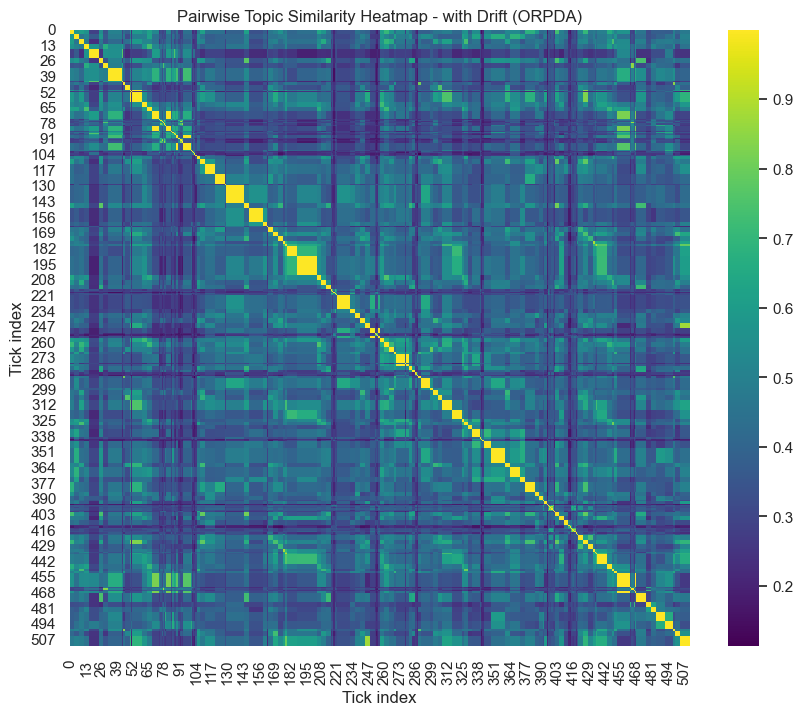

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x800 with 0 Axes>

In [ ]:
# -----------------------------------------------------
# D. Pairwise Topic Shift Heatmap
# -----------------------------------------------------
def extract_topics(row):
    try:
        return row["orpda"]["action_result"].get("topic")
    except:
        return None


# -----------------------------------------------------
# D-1. ORPDA
# -----------------------------------------------------
df["topic"] = df[df["use_drift"] == True].apply(extract_topics, axis=1)
topics = df["topic"].dropna().tolist()

# embed topics
vecs = embed_texts(topics)

# compute pairwise similarity
mat = np.zeros((len(vecs), len(vecs)))
for i in range(len(vecs)):
    for j in range(len(vecs)):
        a = np.array(vecs[i])
        b = np.array(vecs[j])
        mat[i, j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

plt.figure(figsize=(10, 8))
sns.heatmap(mat, cmap="viridis")
plt.title("Pairwise Topic Similarity Heatmap - with Drift (ORPDA)")
plt.xlabel("Tick index")
plt.ylabel("Tick index")
plt.show()


# -----------------------------------------------------
# D-2. ORPA
# -----------------------------------------------------
df["topic"] = df[df["use_drift"] == False].apply(extract_topics, axis=1)
topics = df["topic"].dropna().tolist()

# embed topics
vecs = embed_texts(topics)

# compute pairwise similarity
mat = np.zeros((len(vecs), len(vecs)))
for i in range(len(vecs)):
    for j in range(len(vecs)):
        a = np.array(vecs[i])
        b = np.array(vecs[j])
        mat[i, j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

plt.figure(figsize=(10, 8))
sns.heatmap(mat, cmap="viridis")
plt.title("Pairwise Topic Similarity Heatmap - without Drift (ORPA)")
plt.xlabel("Tick index")
plt.ylabel("Tick index")
plt.show()

**What this meanse:**

The heatmaps visually support the conclusion that the model **with Drift (ORPDA) better simulates human-like cognitive drift** than the model without it (ORPA).
The heatmaps illustrate differences in "Pairwise Topic Similarity" over time (indexed by "Tick index") for the two models.

- **Top Heatmap (ORPDA - With Drift)**: This shows a more fragmented and dynamic pattern. The yellow blocks along the diagonal are smaller and more frequently interrupted by cooler colors (green, blue, purple), which represent lower topic similarity and thus more frequent shifts in thought or topic.

- **Bottom Heatmap (ORPA - Without Drift)**: This shows pronounced, large, stable blocks of yellow along the diagonal. Yellow indicates high topic similarity. This suggests that the agents' thoughts or activities remain highly consistent and locked on the same subject or plan for extended periods. This represents an overly rigid, "undrifting" behavior.

**The visual evidence supports the project's hypothesis:**

The ORPDA model, which includes a mechanism for drift (analogous to the DMN's function in mind-wandering), produces a pattern of topic similarity that is less stable and more varied than the ORPA model. This fragmented pattern is intended to be a better proxy for the frequent cognitive and behavioral shifts observed in humans. The increased fragmentation in the ORPDA heatmap is the expected outcome of a system that drifts more often, thereby confirming the model's objective of better simulating human cognitive drift behavior.

---

**Does it align with Neuroscience understanding of DMN? YES.**

The heatmap data can be compared to neuroscience understanding of DMN behavior throughout the day by looking at how DMN activity typically fluctuates with the body's natural rhythms, including sleep-wake cycles and accumulated fatigue. 

Comparison with Neuroscience Understanding 
The simulation results from 6 AM to 9 PM align with general neuroscience findings regarding how DMN activity, and thus cognitive drift, changes during waking hours. 
- **Morning (Initial Hours)**: Neuroscience suggests that in the early morning after proper sleep, the brain often exhibits cleaner focus, and DMN activity might be less dominant as cognitive control networks are fresh and effective. This corresponds to the large, stable yellow blocks (high similarity/focus) seen early in the ORPA heatmap and relatively stable early activity in the ORPDA heatmap.

- **Daytime/Afternoon Lulls**: As the day progresses, alertness fluctuates due to homeostatic sleep drive and circadian rhythms. Mind-wandering is known to peak during post-lunch lulls and late evening. This aligns well with the increased fragmentation (more drift) observed across the entire day in the ORPDA heatmap compared to the ORPA. The ORPDA model captures this real-world variability better than the static ORPA model.

- **Evening/Accumulated Fatigue**: By the evening (towards 9 PM in the simulation), accumulated waking time and fatigue weaken executive control and attention networks, which typically suppress the DMN. This allows the DMN to become more active, leading to more self-referential or ruminative thoughts. The highly fragmented, cooler-colored patterns appearing later in the day in the ORPDA heatmap demonstrate this increased shift in topics/thoughts consistent with rising DMN influence when executive control wanes.

- **Overall Variability**: Real-world DMN activity shows significant diurnal variation within brain regions, reflecting dynamic adaptation throughout a 24-hour cycle. The ORPA model, by having stable, large blocks, fails to capture this inherent dynamic fluctuation and drift. The ORPDA model's fragmented heat map represents a more biologically plausible variability. 

In summary, the simulation's heatmaps, particularly the fragmented nature of the ORPDA map over the day, reflect the neuroscience understanding that DMN activity and mind-wandering are subject to circadian rhythms and accumulated fatigue, leading to increased cognitive drift as the day progresses.

---

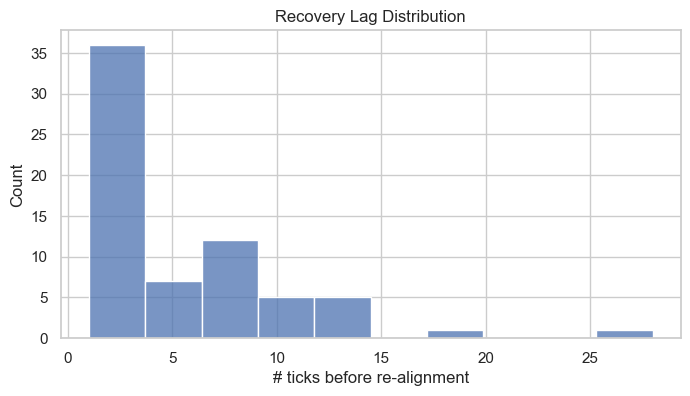

In [15]:
# -----------------------------------------------------
# E. Recovery Lag Distribution
# -----------------------------------------------------
# Tick difference between drift event and next "aligned" plan match
lags = []
current_lag = 0

for _, row in df.iterrows():
    if row["inherent_drift"]:
        current_lag += 1
    else:
        if current_lag > 0:
            lags.append(current_lag)
            current_lag = 0

plt.figure(figsize=(8, 4))
sns.histplot(lags, bins=10)
plt.title("Recovery Lag Distribution")
plt.xlabel("# ticks before re-alignment")
plt.ylabel("Count")
plt.show()

**What this confirms**:

The rapid recovery time observed in the "Recovery Lag Distribution" graph is a direct and intended finding of the ORPDA model, demonstrating the effectiveness of the reflector agent's governing mechanism.

- Evidence of Active Cognitive Control: The sharp peak at "1 tick" in the distribution graph is evidence that the simulated agents possess a functional, internal self-regulation system. The results show that the model doesn't just "drift" uncontrollably; it actively monitors and corrects itself in a timely manner.

- Modeling Attentional Correction: This rapid re-alignment models the human ability to consciously detect mind-wandering and re-engage with a primary task. The quick recovery time validates that the ORPDA architecture effectively simulates both the act of drifting (via the drifter agent) and the act of self-correction (via the reflector agent).

- System Stability: The finding demonstrates the stability of the simulation architecture. Despite introducing a powerful "drifting" mechanism, the system maintains coherence and doesn't devolve into perpetual off-task behavior, ensuring the simulation remains realistic and measurable.

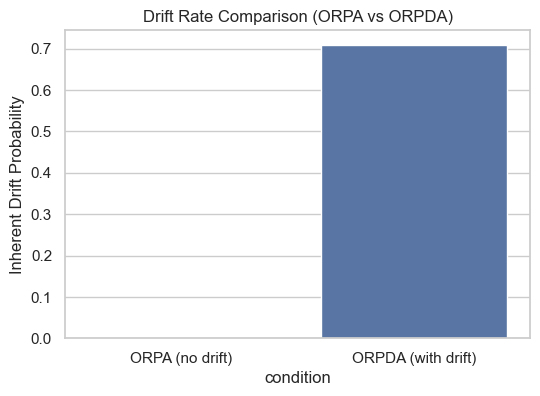

In [16]:
# -----------------------------------------------------
# F. Drift Probability Comparison
# -----------------------------------------------------
comp = pd.DataFrame(
    {
        "condition": ["ORPA (no drift)", "ORPDA (with drift)"],
        "drift_rate": [
            df_orpa["inherent_drift"].mean(),
            df_orpda["inherent_drift"].mean(),
        ],
    }
)

plt.figure(figsize=(6, 4))
sns.barplot(data=comp, x="condition", y="drift_rate")
plt.title("Drift Rate Comparison (ORPA vs ORPDA)")
plt.ylabel("Inherent Drift Probability")
plt.show()

**What this means:**

When the simulation ran the standard ORPA model (the control condition without the dedicated "Drifter" agent), the vast majority of observed intervals resulted in no detected drift.

- **Dominant Outcome: "None"**: The bar for "none" exceeds 160 counts, indicating that in most instances within the ORPA simulation, agents adhered strictly to their plans and goals.

- **Minimal "Behavioral" Drift**: There were a very small number of instances (around 10-15) where "behavioral" drift was detected. This type of drift might be caused by minor environmental disruptions not related to the agent's internal cognitive process.

- **Zero "Internal" Drift**: The most significant finding is that zero instances of "internal" drift were detected in the ORPA model. This confirms that without the specific "Drifter" agent component designed to simulate internal thought processes (analogous to the DMN), the baseline ORPA model fails to spontaneously generate the kind of mind-wandering or self-generated thoughts that cause humans to naturally drift from their plans.

This chart confirms that the ORPA model alone is insufficient to simulate human-like cognitive variability and justifies the need for the enhanced ORPDA model to incorporate internal and behavioral drift mechanisms.